# SPRINT 1.  FINANZAS

### ¿En qué medida los clientes con saldos más bajos están en mayor riesgo de incumplimiento de crédito, y cómo debemos ajustar nuestras políticas de crédito permitir este riesgo?

## 1. IMPORTACIÓN BD I CREACIÓN DEL DF

In [203]:
#Importación de librerias
from sqlalchemy import create_engine, inspect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, time, datetime
%pip install pymysql
import pymysql
plt.style.use('seaborn-v0_8-deep')

#Datos de conexión
usuario='EquipoB'
contraseña="E1q2u3i4p5oB"
host='212.227.90.6'
puerto=3306
nombre_base_datos='EquipB'

#URL de la connexión
url_conexion=f"mysql+pymysql://{usuario}:{contraseña}@{host}:{puerto}/{nombre_base_datos}"

#Creación del engine de SQLAlchemy
try:
    engine=create_engine(url_conexion)
    cnx=engine.connect()
    print("conexión correcta")
except Exception as e:
    print(f"Error al conectar con SQLAlchemy: {e}")
    
#Obtención de los nombres de las tablas
inspector=inspect(engine)
nombre_tablas=inspector.get_table_names()

#Inclusión de la vista_finances en el su DF
if 'vista_finances' not in nombre_tablas:
    nombre_tablas.append('vista_finances')

#Guardar los DataFrames en una lista
df= {}

for taula in nombre_tablas:
    query=f"select * from {taula}"
    
    try:
        df[taula] = pd.read_sql(query, cnx)
        print(f"Tabla '{taula}' cargada correctamente.")
    except Exception as e:
        print(f"Error al cargar la tabla '{taula}':{e}")

#cnx.close()


conexión correcta
Tabla 'BANK_marketing' cargada correctamente.
Tabla 'BANK_marketing131024' cargada correctamente.
Tabla 'vista_finances' cargada correctamente.


Creamos, a partir de una vista creada en SQL, el Data Frame Finanzas con el que trabajaremos a partir de ahora.

In [204]:
df_bank = df['BANK_marketing']
df_finanzas = df['vista_finances']

## 2. EDA: ANÁLISIS EXPLORATÓRIO

Comprobación de los primeros registros del dataframe y de la información clave de los campos.

In [205]:
df_finanzas.head()

,id,age,job,marital,education,faltante,balance,housing,loan
0,1,59,admin.,married,secondary,0,2343,1,0
1,3,56,admin.,married,secondary,0,45,0,0
2,4,41,technician,married,secondary,0,1270,1,0
3,5,55,services,married,secondary,0,2476,1,0
4,6,54,admin.,married,tertiary,0,184,0,0


In [206]:
df_finanzas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         11162 non-null  int64 
 1   age        11162 non-null  int64 
 2   job        11162 non-null  object
 3   marital    11162 non-null  object
 4   education  11162 non-null  object
 5   faltante   11162 non-null  int64 
 6   balance    11162 non-null  int64 
 7   housing    11162 non-null  int64 
 8   loan       11162 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 785.0+ KB


In [207]:
df_finanzas.describe()

,id,age,faltante,balance,housing,loan
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,5582.499910,41.232754,0.015051,1528.538524,0.473123,0.130801
std,3222.336342,11.910672,0.121761,3225.413326,0.499299,0.337198
min,1.000000,18.000000,0.000000,-6847.000000,0.000000,0.000000
25%,2792.250000,32.000000,0.000000,122.000000,0.000000,0.000000
50%,5582.500000,39.000000,0.000000,550.000000,0.000000,0.000000
75%,8372.750000,49.000000,0.000000,1708.000000,1.000000,0.000000
max,11163.000000,95.000000,1.000000,81204.000000,1.000000,1.000000


Primer análisis de las 2 variables que nos ayudarán a dar respuesta a la pregunta del sprint.

In [208]:
df_finanzas['faltante'].value_counts()

faltante
0    10994
1      168
Name: count, dtype: int64

In [209]:
df_finanzas['faltante'].isnull().sum()

0

In [210]:
df_finanzas['balance'].value_counts()

balance
 0       774
 1        39
 3        35
 2        34
 4        29
        ... 
 5517      1
 8332      1
 4859      1
-267       1
-134       1
Name: count, Length: 3805, dtype: int64

In [211]:
df_finanzas['balance'].isnull().sum()

0

Detección de Outliers en la variable numérica 'balance'.

In [212]:
Q1 = df_finanzas['balance'].quantile(0.25)
Q3 = df_finanzas['balance'].quantile(0.75)
IQR = Q3 - Q1

outliers = (df_finanzas['balance'] < (Q1-1.5*IQR)) | (df_finanzas['balance'] > (Q3 + 1.5*IQR))
outliers.sum()



1055

In [213]:
(outliers.sum())/(df_finanzas['balance'].count()) * 100

9.451711162874037

Tenemos un 9,45% de Outliers en 'balance'

### 2.1 VISUALIZACIONES

#### FALTANTE

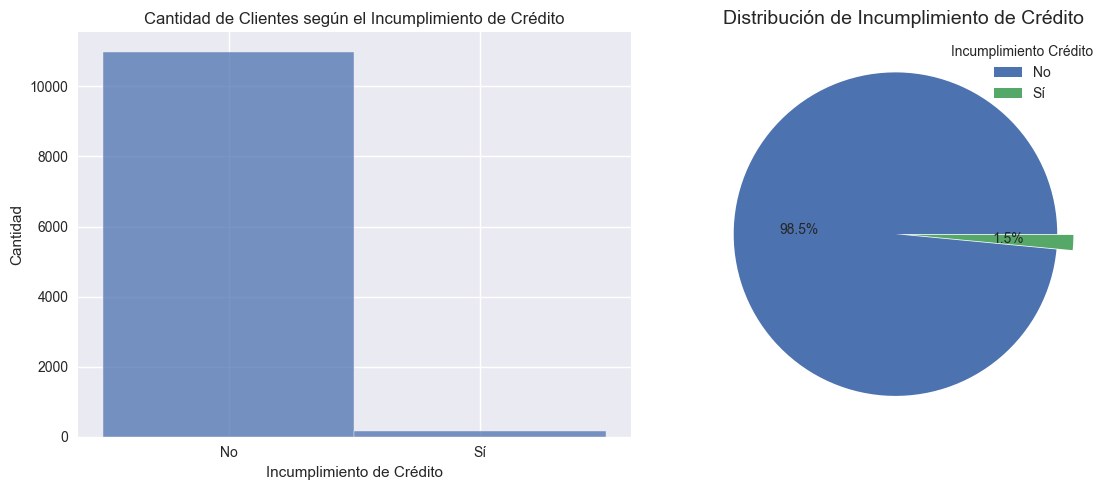

In [214]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))



sns.histplot(data=df_finanzas, x='faltante', ax=axs[0], discrete=True)
axs[0].set_title('Cantidad de Clientes según el Incumplimiento de Crédito')
axs[0].set_xlabel('Incumplimiento de Crédito')
axs[0].set_ylabel('Cantidad')
axs[0].set_xticks([0, 1])
axs[0].set_xticklabels(["No", "Sí"])

recuento_default = df_finanzas['faltante'].value_counts().reset_index(name="cantidad")
explode = (0.05, 0.05)  
axs[1].pie(recuento_default["cantidad"], autopct='%1.1f%%', explode=explode)
axs[1].set_title("Distribución de Incumplimiento de Crédito", fontsize=14)

axs[1].legend(title="Incumplimiento Crédito", labels=["No", "Sí"])
plt.tight_layout()
plt.show()

Solo el 1,5% de los clientes están en incumplimiento de crédito.

#### BALANCE

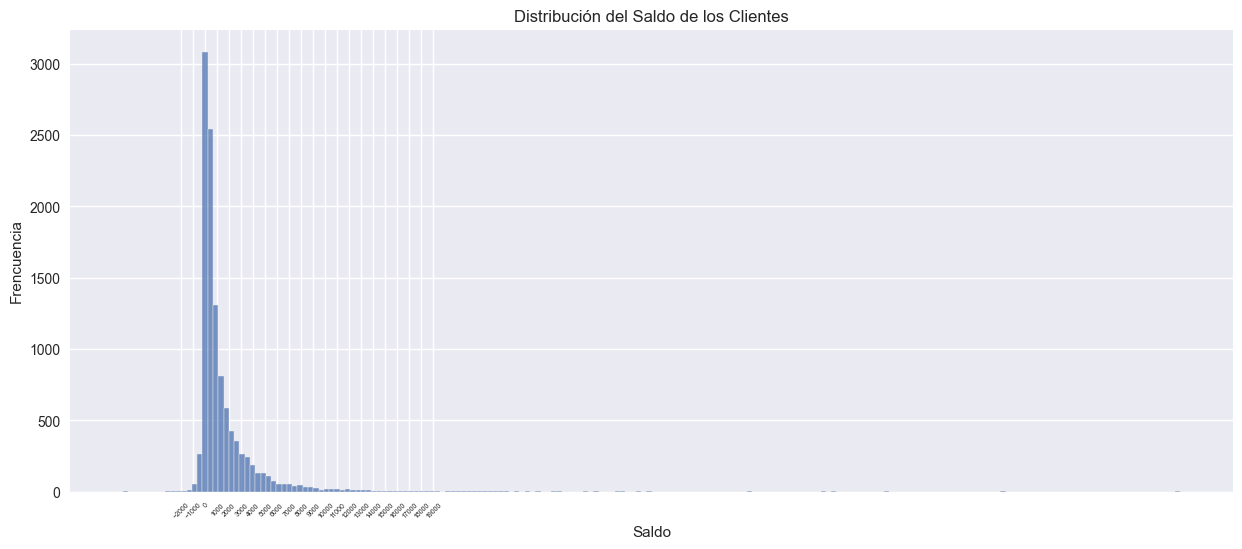

In [215]:
plt.figure(figsize=(15, 6))

sns.histplot(data=df_finanzas, x='balance', bins=200)

plt.title('Distribución del Saldo de los Clientes')
plt.xlabel('Saldo')
plt.ylabel('Frencuencia')
plt.xticks(range(-2000,20000,1000), fontsize= 5, rotation= 45)
plt.show()

Podemos ver una distribución asimétrica con cola a la derecha. Hay un pico muy destacado alrededor del 0 donde se encuentran la inmensa mayoría de registros. 
La mayoría de clientes tienen saldos entre -500 y 1000, mientras que muy pocos clientes tienen saldos muy altos, de más de 50.000.

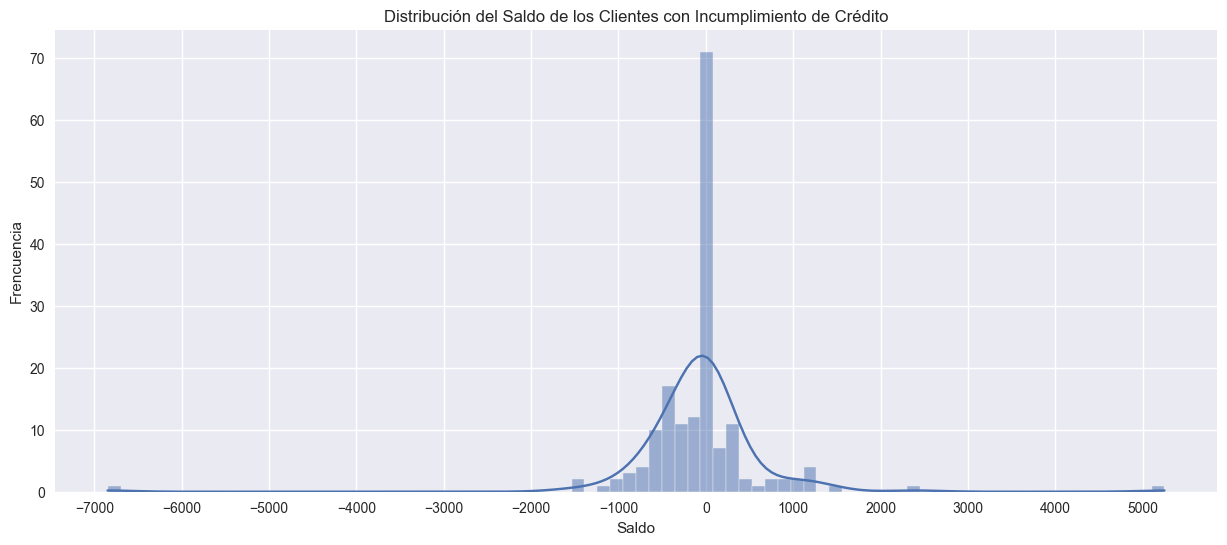

In [216]:
con_incumplimiento_credito = df_finanzas.query('faltante == 1')

plt.figure(figsize=(15, 6))

sns.histplot(data=con_incumplimiento_credito, x='balance', kde = True)

plt.xticks(np.arange(-7000,6000,1000))

plt.title('Distribución del Saldo de los Clientes con Incumplimiento de Crédito')
plt.xlabel('Saldo')
plt.ylabel('Frencuencia')
plt.show()

La distribución de los clientes en Incumplimiento de Crédito es simétrica y normal.

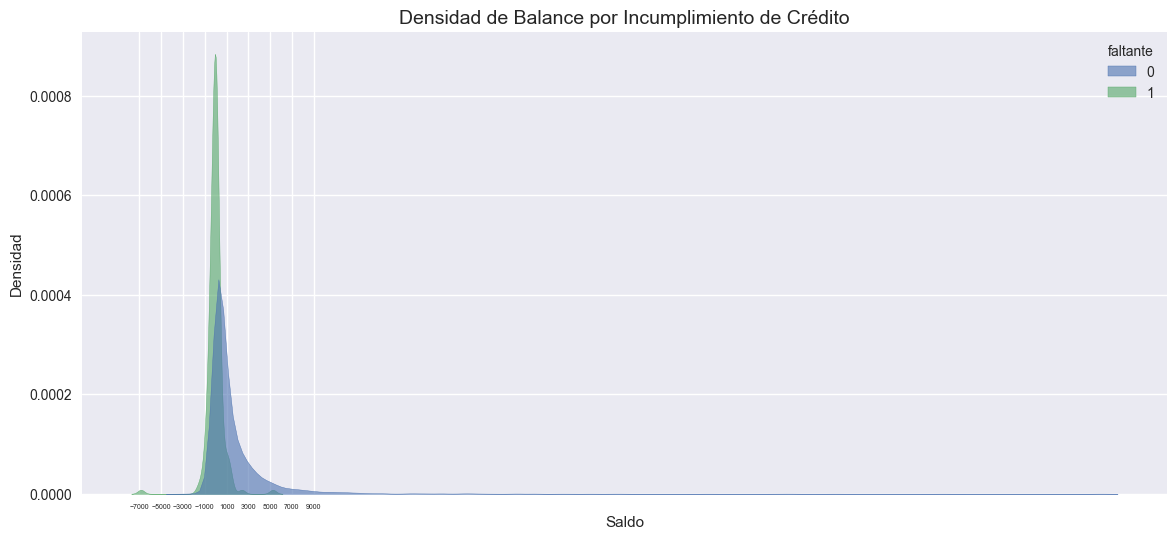

In [217]:
plt.figure(figsize=(14, 6))

ax = sns.kdeplot(data=df_finanzas, x='balance', hue='faltante', hue_order= [0, 1], fill=True, common_norm=False, alpha=0.6)

plt.title('Densidad de Balance por Incumplimiento de Crédito', fontsize=14)
plt.xlabel('Saldo')
plt.ylabel('Densidad')
handles, labels = ax.get_legend_handles_labels()
if len(handles) == 2:
    ax.legend(handles, ['No', 'Sí'], title='Incumplimiento')
plt.xticks(range(-7000,10000,2000), fontsize=5)

plt.show()

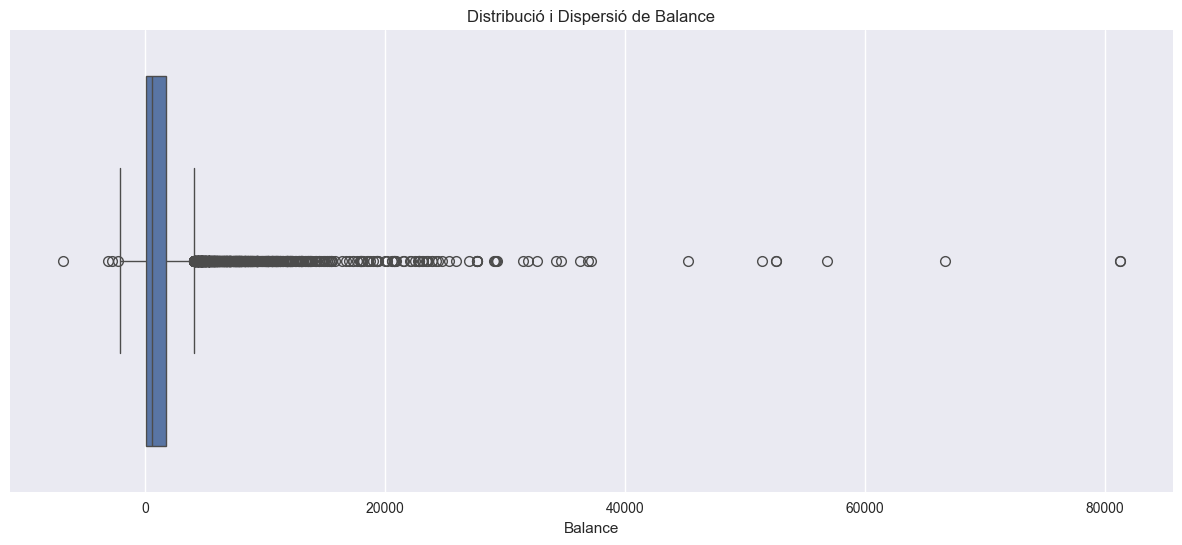

In [218]:
plt.figure(figsize=(15,6))
sns.boxplot(x=df_finanzas['balance'])
plt.title('Distribució i Dispersió de Balance')
plt.xlabel('Balance')
plt.show()

Vemos una caja entre Q1 y Q3 muy estrecha y, por tanto una gran concentración de clientes con 'balance' cerca del 0.
Vemos el gran número de outliers que aparecen , sobre todo por la derecha, confirmando lo que mostraba el primer análisis numérico de outliers.
Parecería que la inmensa mayoría de clientes utilizan el banco como banco de gestión de nóminas y pagos corrientes y solo una pequeña parte lo utiliza también como banco de inversión y ahorro.
También se puede valorar la posibilidad de que, esta distribución de 'balance', represente la distribución de la riqueza en la sociedad del país y que, por tanto, podamos inferir que se trata de un país donde la inmensa mayoría de la gente no tiene ahorros, mientras que un pequeña minoría sí lo tiene.

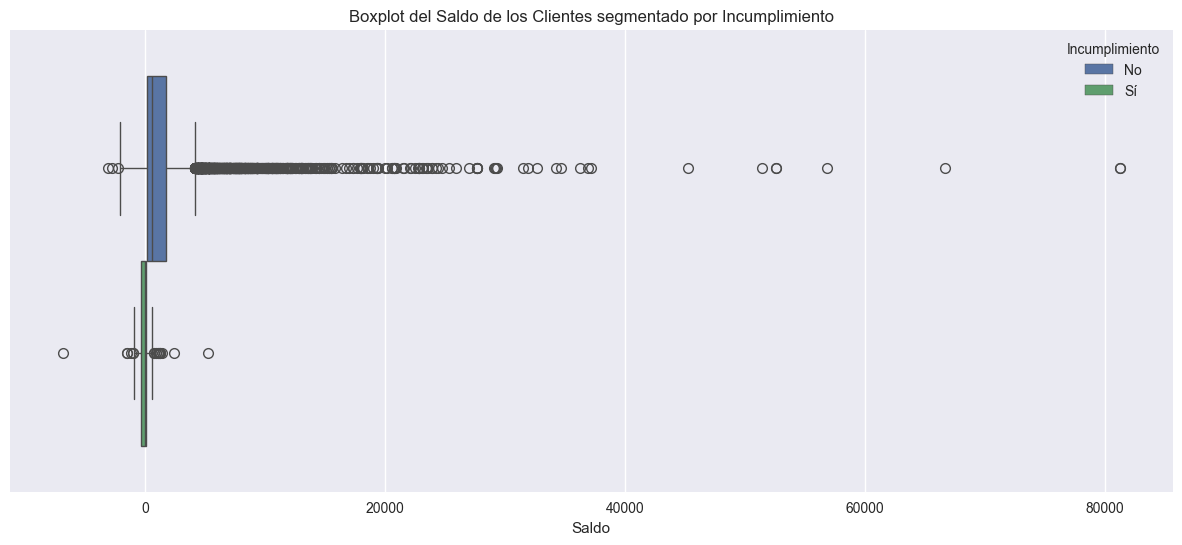

In [219]:
plt.figure(figsize=(15, 6))

ax= sns.boxplot(data=df_finanzas, x = 'balance', hue = 'faltante', hue_order=[0, 1])

plt.title('Boxplot del Saldo de los Clientes segmentado por Incumplimiento')
plt.xlabel('Saldo')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['No', 'Sí'], title='Incumplimiento')
plt.show()

Vemos que el saldo de los clientes que no incumplieron con el crédito presenta muchos más outliers y está más disperso. En cambio, los saldos de los que sí incumplieron con su crédito estan más concentrados alrededor de 0. 

### OUTLIERS
Viendo la distribución de "balance" y la gran cantidad de outliers (9,45%) se nos presentan varias opciones para su tratamiento: 
* Dejarlos: Camino que seguiremos en paralelo para luego ponerlo en común.
* Eliminarlos: Aplicando la formula +- 1.5 * IQR.
* Truncar los valores en un tope determinado
* Estandarizar
* Aplicar una transformación logarítmica

Analizamos la composición de los outliers con más detenimiento.

In [220]:
df_outliers = df_finanzas[outliers]

print(df_outliers.describe())
print(df_outliers.info())

                 id          age     faltante       balance      housing  \
count   1055.000000  1055.000000  1055.000000   1055.000000  1055.000000   
mean    5140.026540    44.426540     0.001896   8413.330806     0.399052   
std     3183.738561    13.070966     0.043519   6943.962727     0.489936   
min       11.000000    20.000000     0.000000  -6847.000000     0.000000   
25%     2520.500000    34.000000     0.000000   4929.500000     0.000000   
50%     4698.000000    42.000000     0.000000   6281.000000     0.000000   
75%     7907.500000    53.000000     0.000000   9203.000000     1.000000   
max    11103.000000    87.000000     1.000000  81204.000000     1.000000   

              loan  
count  1055.000000  
mean      0.063507  
std       0.243988  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       0.000000  
max       1.000000  
<class 'pandas.core.frame.DataFrame'>
Index: 1055 entries, 9 to 11101
Data columns (total 9 columns):
 #   Column     Non-Null

Text(0.5, 1.0, 'DISTRIBUCIÓN DE OUTLIERS')

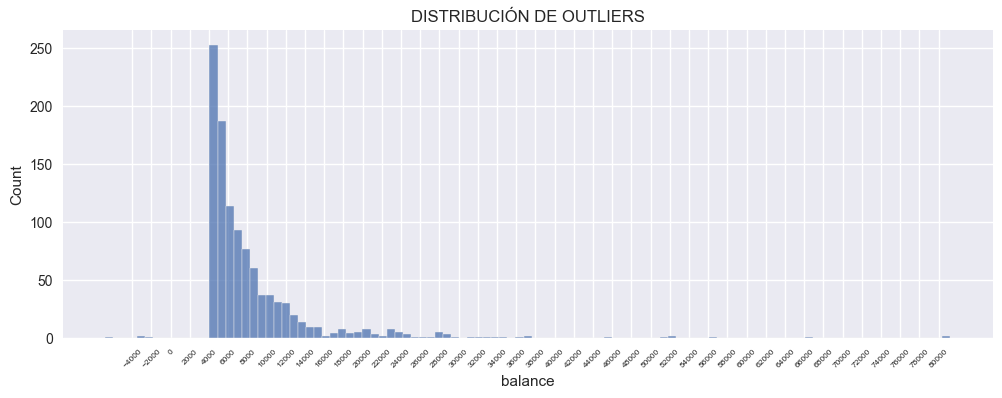

In [221]:
plt.figure(figsize=(12,4))
sns.histplot(df_outliers['balance'])
plt.xticks(range(-4000,82000,2000),fontsize = 6, rotation = 45)
plt.title('DISTRIBUCIÓN DE OUTLIERS')

Viendo la distribuición tan asimétrica de los outliers, totalmente decantada hacia los valores más altos, decidimos aplicar una transformación logarítmica, ya que es el mejor método para valores muy altos en distribuciones con mucha dispersión.

Descartamos los otros métodos:

Eliminarlos sería desvirtuar la muestra y alterar totalmente los datos reales. 
Para truncarlos necesitaria aplicar un valor de límite y necessitaria un mayor conocimiento de la muestra y del mundo financiero. Además también alterariamos la muestra.
La estandarización sería una solución más neutra y no altera los datos pero tampoco resuelve el problema de la "deformación" de la muestra por culpa de los numerosos y muy extremos outliers.

La transformación logaritmica sí corrige la "deformación" de la muestra por los outliers, pero tambien varia en cierta medida la relación entre los valores, cosa que consideramos un mal menor de poco impacto.
El único impedimento para realizarlo es que no se puede aplicar con valores negativos así que optamos por la solucion más fácil e inocua: Sumar una constante del valor mínimo + 1 a todos los valores y después aplicar la transformacion logarítmica con el logarimo natural de cada valor resultante:

log(x+(min+1))

In [222]:
min_balance = df_finanzas['balance'].min()
df_finanzas['balance_log'] = np.log(df_finanzas['balance'] + abs(min_balance) + 1)
df_finanzas[['balance', 'balance_log']].head()

,balance,balance_log
0,2343,9.125980
1,45,8.838262
2,1270,9.001839
3,2476,9.140347
4,184,8.858226


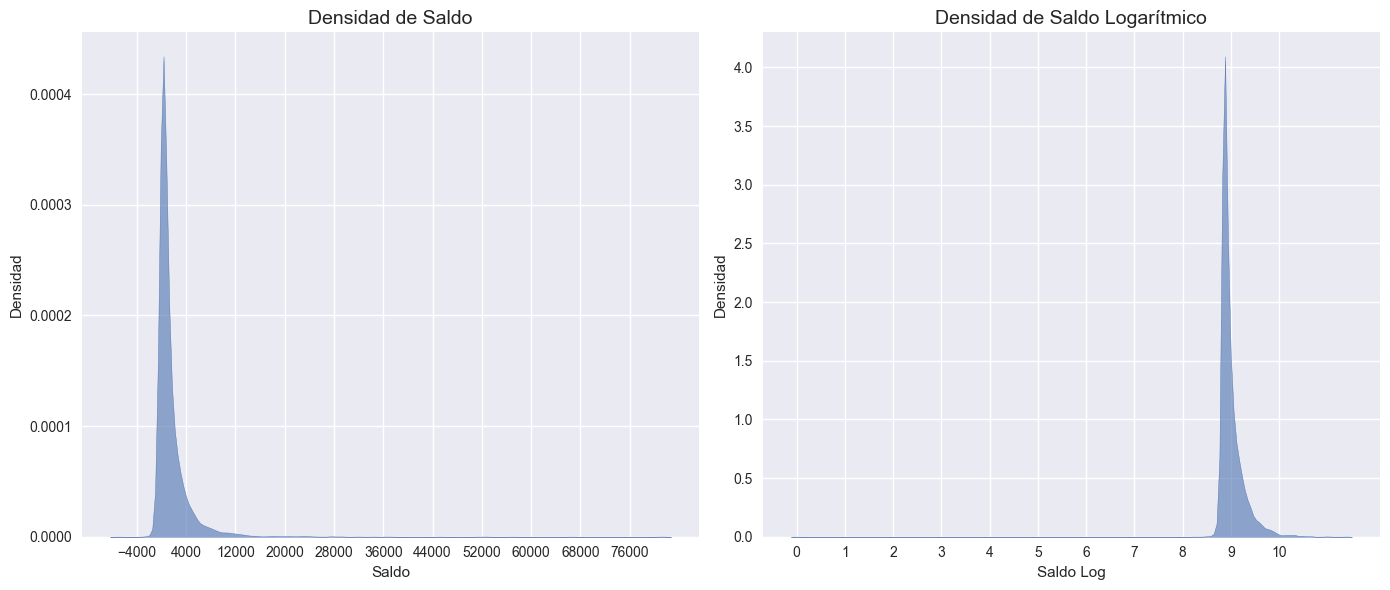

In [223]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Gràfic de densitat per a 'balance'
sns.kdeplot(data=df_finanzas, x='balance', fill=True, common_norm=False, alpha=0.6, ax=axes[0])
axes[0].set_title('Densidad de Saldo', fontsize=14)
axes[0].set_xlabel('Saldo')
axes[0].set_ylabel('Densidad')
axes[0].set_xticks(range(-4000, 80000, 8000))

# Gràfic de densitat per a 'balance_log'
sns.kdeplot(data=df_finanzas, x='balance_log',fill=True, common_norm=False, alpha=0.6, ax=axes[1])
axes[1].set_title('Densidad de Saldo Logarítmico', fontsize=14)
axes[1].set_xlabel('Saldo Log')
axes[1].set_ylabel('Densidad')
axes[1].set_xticks(range(int(df_finanzas['balance_log'].min()), int(df_finanzas['balance_log'].max()), 1))

plt.tight_layout()
plt.show()


Comprobamos que tras el tratamiento logarítmico de los Outliers la distribución de 'balance' no varia practicamente en nada.

Como detallaremos más adelante, realizaremos una categorización de 'balance' para su comparación con 'faltante'. 
Realizamos la categorización de dos maneras: con el tratamiento logarítmico de Outliers y sin tratarlos. Así podremos comparar su impacto antes de profundizar en el análisis comparativo de las dos variables.

Calculamos los cuartiles el trtamiento logarítmico.

In [224]:
def cuartiles(df):
    #calcular cuartiles
    Q1 = df.quantile(0.25)
    Q2 = df.quantile(0.50)
    Q3 = df.quantile(0.75)

    #calcular IQR (rango intercuartílico)
    IQR = Q3 - Q1

    #calcular límite outliers
    min_Q = Q1 - 1.5*IQR
    max_Q = Q3 + 1.5*IQR
    
    return Q1, Q2, Q3, min_Q, max_Q

Q1, Q2, Q3, min_Q, max_Q = cuartiles(df_finanzas['balance_log'])

Asignamos las categorias según los cuartiles creados.

In [225]:
def clasificacion_clientes (balance):
    if balance < min_Q:
        return 'muy bajo'
    elif balance < Q1:
        return 'bajo'
    elif balance < Q2:
        return 'medio-bajo'
    elif balance < Q3:
        return 'medio-alto'
    elif balance < max_Q:
        return 'alto'
    else:
        return 'muy alto'
    
df_finanzas['descripcion_balance_log'] = df_finanzas['balance_log'].apply(clasificacion_clientes)

df_finanzas.head()

,id,age,job,marital,education,faltante,balance,housing,loan,balance_log,descripcion_balance_log
0,1,59,admin.,married,secondary,0,2343,1,0,9.125980,alto
1,3,56,admin.,married,secondary,0,45,0,0,8.838262,bajo
2,4,41,technician,married,secondary,0,1270,1,0,9.001839,medio-alto
3,5,55,services,married,secondary,0,2476,1,0,9.140347,alto
4,6,54,admin.,married,tertiary,0,184,0,0,8.858226,medio-bajo


In [226]:
df_finanzas['balance_log'].min()
df_finanzas['balance_log'].max()

11.385682828033222

Ahora comparamos las dos variables categoricas, creando la media de incumpliento por cada categoria de balance para visualizarlo.

<function matplotlib.pyplot.show(close=None, block=None)>

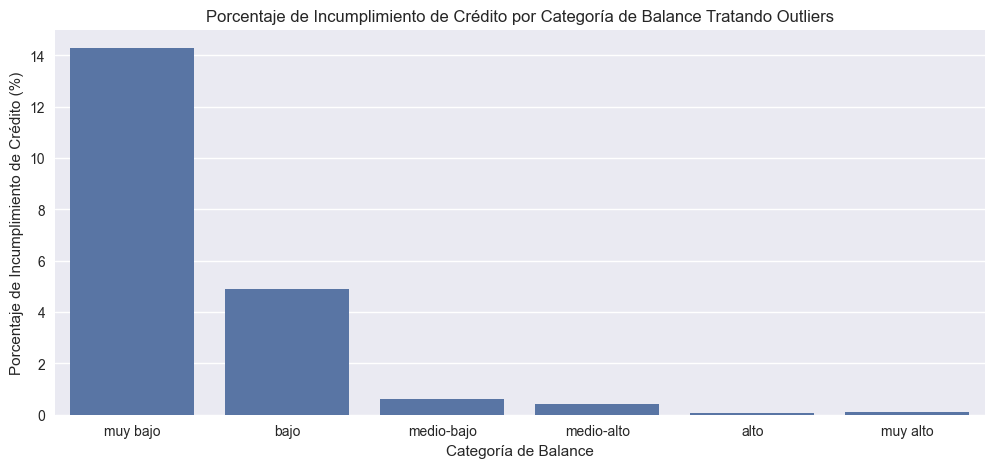

In [227]:
# volvemos a convertir los valores de incumplimiento a numéricos para calcular el % 
incumplimiento_categoria = df_finanzas.groupby('descripcion_balance_log')['faltante'].mean() * 100
# Convertimos a un DataFrame para facilitar la visualización
incumplimiento_categoria = incumplimiento_categoria.reset_index()

order = ['muy bajo', 'bajo', 'medio-bajo', 'medio-alto', 'alto', 'muy alto']
plt.figure(figsize=(12, 5))
sns.barplot(data=incumplimiento_categoria, x='descripcion_balance_log', y='faltante', order = order)
plt.title('Porcentaje de Incumplimiento de Crédito por Categoría de Balance Tratando Outliers')
plt.xlabel('Categoría de Balance')
plt.ylabel('Porcentaje de Incumplimiento de Crédito (%)')
plt.show


Ahora realizamos la categorización sin usar el tratamiento logaritmico.

In [228]:
def cuartiles(df):
    #Calcular cuartiles
    Q1 = df.quantile(0.25)
    Q2 = df.quantile(0.50)
    Q3 = df.quantile(0.75)

    #Calcular IQR (rango intercuartílico)
    IQR = Q3 - Q1

    #Calcular límite outliers
    min_Q = Q1 - 1.5*IQR
    max_Q = Q3 + 1.5*IQR
    
    return Q1, Q2, Q3, min_Q, max_Q

Q1, Q2, Q3, min_Q, max_Q = cuartiles(df_finanzas['balance'])

In [229]:
def clasificacion_clientes (balance):
    if balance < min_Q:
        return 'muy bajo'
    elif balance < Q1:
        return 'bajo'
    elif balance < Q2:
        return 'medio-bajo'
    elif balance < Q3:
        return 'medio-alto'
    elif balance < max_Q:
        return 'alto'
    else:
        return 'muy alto'
    
df_finanzas['descripcion_balance'] = df_finanzas['balance'].apply(clasificacion_clientes)

df_finanzas.head()

,id,age,job,marital,education,faltante,balance,housing,loan,balance_log,descripcion_balance_log,descripcion_balance
0,1,59,admin.,married,secondary,0,2343,1,0,9.125980,alto,alto
1,3,56,admin.,married,secondary,0,45,0,0,8.838262,bajo,bajo
2,4,41,technician,married,secondary,0,1270,1,0,9.001839,medio-alto,medio-alto
3,5,55,services,married,secondary,0,2476,1,0,9.140347,alto,alto
4,6,54,admin.,married,tertiary,0,184,0,0,8.858226,medio-bajo,medio-bajo


<function matplotlib.pyplot.show(close=None, block=None)>

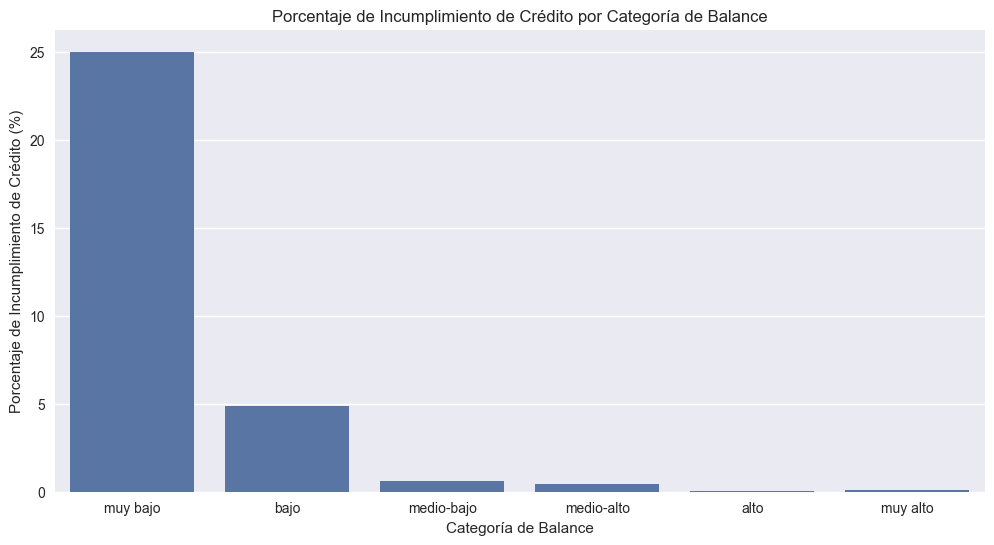

In [230]:
#Calculamos la media
incumplimiento_categoria = df_finanzas.groupby('descripcion_balance')['faltante'].mean() * 100

#Convertimos a un DataFrame para facilitar la visualización
incumplimiento_categoria = incumplimiento_categoria.reset_index()

order = ['muy bajo', 'bajo', 'medio-bajo', 'medio-alto', 'alto', 'muy alto']
plt.figure(figsize=(12, 6))
sns.barplot(data=incumplimiento_categoria, x='descripcion_balance', y='faltante', order = order)
plt.title('Porcentaje de Incumplimiento de Crédito por Categoría de Balance')
plt.xlabel('Categoría de Balance')
plt.ylabel('Porcentaje de Incumplimiento de Crédito (%)')
plt.show


Comprobamos que tras el tratamiento logarítmico de los Outliers la distribución del porcentaje de incumplimiento en cada categoria no varia practicamente en nada, solo una pequeña variación entre las categorias alto y muy alto que son las menos pobladas. 
Por todo ello continuamos el análisis sin tratar los Outliers.

## 3. ANÁLISIS COMPARATIVO BALANCE Vs DEFAULT


Necesitamos averiguar si hay alguna relación entre el saldo y el incumplimiento de crédito, y en qué medida. 
Para ello, consideramos que la mejor opción es agrupar los clientes en función del balance presente en sus cuentas y, así, poder calcular el % de incumplimiento de cada grupo y ver si existe alguna tendencia. 

Para el criterio de clasificación utilizaremos los cuartiles.

In [231]:
df_finanzas['balance'].describe()

count    11162.000000
mean      1528.538524
std       3225.413326
min      -6847.000000
25%        122.000000
50%        550.000000
75%       1708.000000
max      81204.000000
Name: balance, dtype: float64

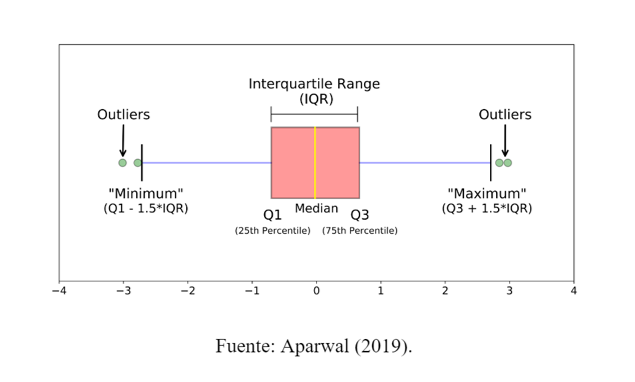

In [232]:
def cuartiles(df):
    #calcular cuartiles
    Q1 = df.quantile(0.25)
    Q2 = df.quantile(0.50)
    Q3 = df.quantile(0.75)

    #calcular IQR (rango intercuartílico)
    IQR = Q3 - Q1

    #calcular límite outliers
    min_Q = Q1 - 1.5*IQR
    max_Q = Q3 + 1.5*IQR
    
    return Q1, Q2, Q3, min_Q, max_Q

Q1, Q2, Q3, min_Q, max_Q = cuartiles(df_finanzas['balance'])

print(f'Minimum: {min_Q}\n'
      f'Q1: {Q1}\n'
      f'Q2: {Q2}\n'
      f'Q3: {Q3}\n'
      f'Maximum: {max_Q}')

Minimum: -2257.0
Q1: 122.0
Q2: 550.0
Q3: 1708.0
Maximum: 4087.0


Creación de categorias de clientes

In [233]:
def clasificacion_clientes (balance):
    if balance < min_Q:
        return 'muy bajo'
    elif balance < Q1:
        return 'bajo'
    elif balance < Q2:
        return 'medio-bajo'
    elif balance < Q3:
        return 'medio-alto'
    elif balance < max_Q:
        return 'alto'
    else:
        return 'muy alto'
    
df_finanzas['descripcion_balance'] = df_finanzas['balance'].apply(clasificacion_clientes)

Clasificamos a los clientes según su 'balance'. Incluimos categorías específicas para tratar con los outliers negativos (categoría muy bajo) y positivos (categoría muy alto) por separado.
* Muy bajo: 
    * balance < -2257
* Bajo: 
    * -2257 ≤ balance < 122
* Medio-bajo:
    * 122 ≤ balance < 550
* Medio-alto:
    * 550 ≤ balance < 1708
* Alto:
    * 1708 ≤ balance < 4087
* Muy alto:
    * balance > 4087

In [234]:
df_finanzas.head()

,id,age,job,marital,education,faltante,balance,housing,loan,balance_log,descripcion_balance_log,descripcion_balance
0,1,59,admin.,married,secondary,0,2343,1,0,9.125980,alto,alto
1,3,56,admin.,married,secondary,0,45,0,0,8.838262,bajo,bajo
2,4,41,technician,married,secondary,0,1270,1,0,9.001839,medio-alto,medio-alto
3,5,55,services,married,secondary,0,2476,1,0,9.140347,alto,alto
4,6,54,admin.,married,tertiary,0,184,0,0,8.858226,medio-bajo,medio-bajo


Text(0, 0.5, 'Cantidad')

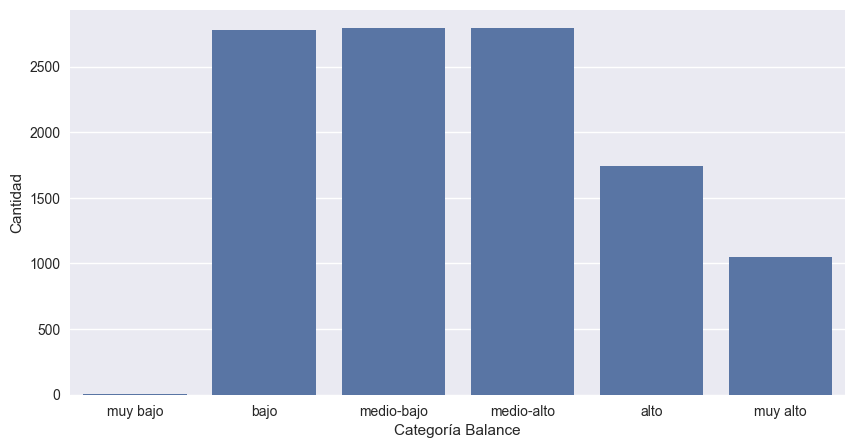

In [235]:
categorias_balance = df_finanzas["descripcion_balance"].value_counts().reset_index(name="cantidad")

order = ['muy bajo', 'bajo', 'medio-bajo', 'medio-alto', 'alto', 'muy alto']

plt.figure(figsize=(10,5))
sns.barplot(data=categorias_balance, x="descripcion_balance", y="cantidad", order=order)

plt.xlabel("Categoría Balance")
plt.ylabel("Cantidad")

Prácticamente no hay valores muy bajos.

In [236]:
#crear tabla con la cantidad de incumplimientos de créditos por categoría de balance
si_incumplimiento = df_finanzas.query("faltante == 1").groupby(by="descripcion_balance").size().reset_index(name="si")
no_incumplimiento = df_finanzas.query("faltante == 0").groupby(by="descripcion_balance").size().reset_index(name="no")

balance_incumplimiento = pd.merge(no_incumplimiento, si_incumplimiento, on="descripcion_balance")

#calcular el porcentaje de incumplimiento de crédito para cada categoría
balance_incumplimiento["% incumplimiento"] = (balance_incumplimiento['si']/(balance_incumplimiento['si']+balance_incumplimiento['no']))*100

#ordenar las categorías
balance_incumplimiento['descripcion_balance'] = pd.Categorical(balance_incumplimiento['descripcion_balance'], categories=order, ordered=True)
balance_incumplimiento = balance_incumplimiento.sort_values(by='descripcion_balance').reset_index(drop=True)

balance_incumplimiento

,descripcion_balance,no,si,% incumplimiento
0,muy bajo,3,1,25.000000
1,bajo,2643,136,4.893847
2,medio-bajo,2777,17,0.608447
3,medio-alto,2781,12,0.429646
4,alto,1739,1,0.057471
5,muy alto,1051,1,0.095057


En la tabla vemos que la categoría de balance muy bajo (outliers negativos) únicamente tiene 4 muestras, por lo que el porcentaje de incumplimiento es muy elevado en comparación a las otras. Hay que vigilar las conclusiones que sacamos de aquí.

Teniendo en cuenta esto, intentaremos aplicar métodos matemáticos y/o estadísticos para intentar mitigar el efecto del desbalance de la muestra y comparar los resultados. 

Text(0, 0.5, 'Porcentaje de Incumplimiento')

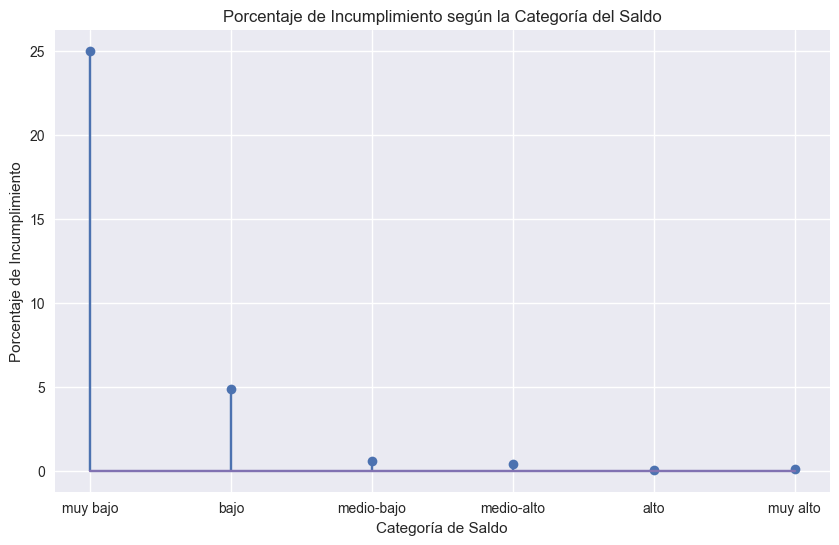

In [237]:
plt.figure(figsize=(10,6))

plt.stem(balance_incumplimiento['descripcion_balance'],balance_incumplimiento['% incumplimiento'])

plt.title("Porcentaje de Incumplimiento según la Categoría del Saldo")
plt.xlabel("Categoría de Saldo")
plt.ylabel("Porcentaje de Incumplimiento")

#### Podemos observar que hay una relación inversa entre las dos variables. 
#### A mayor saldo , menor tasa de incumplimiento.

Pensando en una categorización más eficaz y en el tratamiento de los Outliers no surge una pregunta:
¿Cómo varian los porcentajes de incumplimiento si incluimos los valores muy bajos en la categoría de balance bajo y los valores muy altos en la categoría de balance alto?
Es decir, ¿Cómo variarán los porcentajes si usamos solo 4 categorias en lugar de 6?

In [238]:
df_finanzas_2 = df_finanzas.copy()

df_finanzas_2['descripcion_balance'] = df_finanzas_2['descripcion_balance'].replace({"muy bajo":"bajo", "muy alto": "alto"})

balance_incumplimiento_2 = pd.merge(df_finanzas_2.query("faltante == 0").groupby(by="descripcion_balance").size().reset_index(name="no"), 
                                    df_finanzas_2.query("faltante == 1").groupby(by="descripcion_balance").size().reset_index(name="si"), 
                                    on="descripcion_balance")

#calcular el porcentaje de incumplimiento de crédito para cada categoría
balance_incumplimiento_2["% incumplimiento"] = (balance_incumplimiento_2['si']/
                                                (balance_incumplimiento_2['si']+balance_incumplimiento_2['no']))*100

#ordenar las categorías
balance_incumplimiento_2['descripcion_balance'] = pd.Categorical(balance_incumplimiento_2['descripcion_balance'], 
                                                                            categories=['bajo','medio-bajo','medio-alto','alto'], 
                                                                            ordered=True)

balance_incumplimiento_2 = balance_incumplimiento_2.sort_values(by='descripcion_balance').reset_index(drop=True)

balance_incumplimiento_2

,descripcion_balance,no,si,% incumplimiento
0,bajo,2646,137,4.922745
1,medio-bajo,2777,17,0.608447
2,medio-alto,2781,12,0.429646
3,alto,2790,2,0.071633


Text(0, 0.5, 'Porcentaje de Incumplimiento')

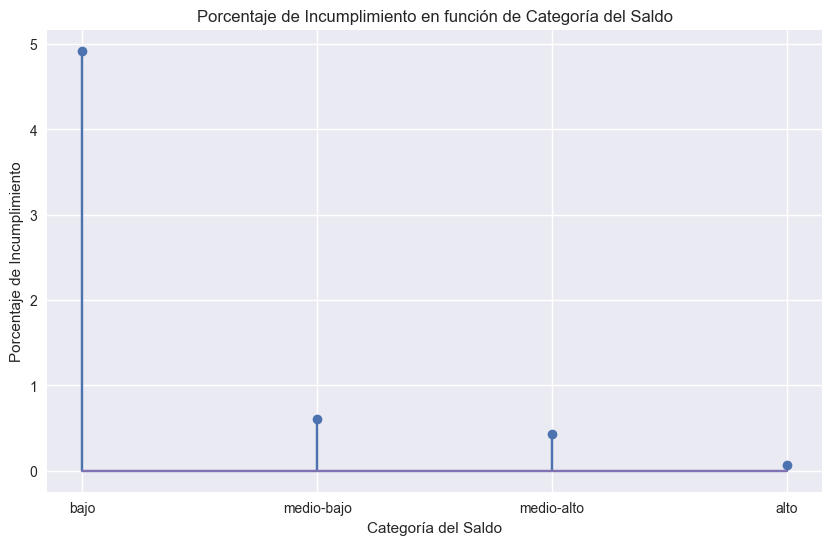

In [239]:
plt.figure(figsize=(10,6))

plt.stem(balance_incumplimiento_2['descripcion_balance'],balance_incumplimiento_2['% incumplimiento'])

plt.title("Porcentaje de Incumplimiento en función de Categoría del Saldo")
plt.xlabel("Categoría del Saldo")
plt.ylabel("Porcentaje de Incumplimiento")

In [240]:
diferencia_incumplimiento = pd.merge(balance_incumplimiento,
                                     balance_incumplimiento_2,
                                     on='descripcion_balance')

diferencia_incumplimiento = diferencia_incumplimiento[['descripcion_balance', '% incumplimiento_x', '% incumplimiento_y']]
diferencia_incumplimiento['diferencia'] = diferencia_incumplimiento['% incumplimiento_y'] - diferencia_incumplimiento['% incumplimiento_x']

diferencia_incumplimiento

,descripcion_balance,% incumplimiento_x,% incumplimiento_y,diferencia
0,bajo,4.893847,4.922745,0.028899
1,medio-bajo,0.608447,0.608447,0.000000
2,medio-alto,0.429646,0.429646,0.000000
3,alto,0.057471,0.071633,0.014162


Text(0.5, 1.0, 'Diferencia de % Incumplimiento')

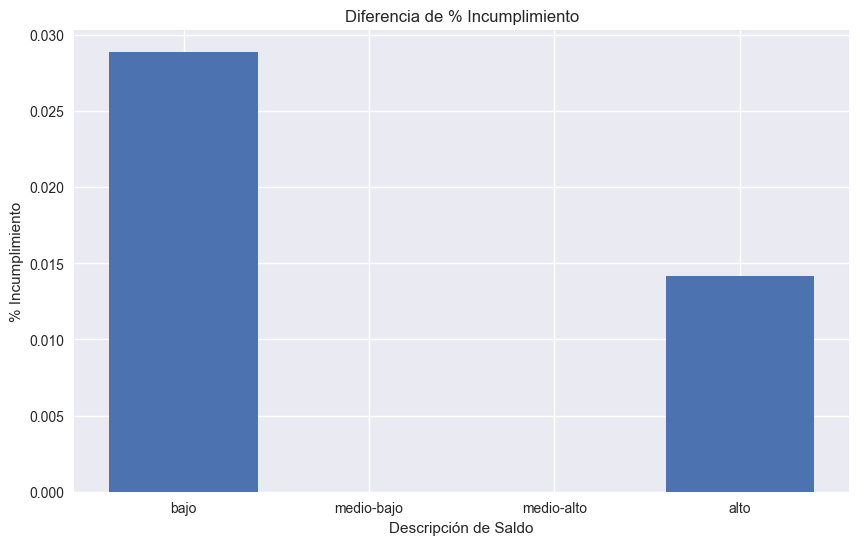

In [241]:
plt.figure(figsize=(10, 6))

plt.bar(diferencia_incumplimiento['descripcion_balance'], diferencia_incumplimiento['diferencia'])

plt.xlabel('Descripción de Saldo')
plt.ylabel('% Incumplimiento')
plt.title('Diferencia de % Incumplimiento')

Cambiando la categorización de 6 a 4 categorias, las diferéncias en los porcentajes de incumplimiento son mínimas (como mucho 0.03%).

Por lo tanto decidimos continuar el análisis con las 4 categorias.

En los gráficos de porcentaje de incumplimiento por categoria hemos podido observar que hay una relación inversa entre las dos variables. A mayor saldo , menor tasa de incumplimiento.
Realizamos una comparación con otra gráfica con mayor número de categorias, creadas de manera automática, sin tener en cuenta ninguna ponderación ni los cuartiles.

C:\Users\ueret\AppData\Local\Temp\ipykernel_16668\2507903613.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  incumplimiento_por_bin = df_finanzas.groupby('balance_bins')['faltante'].mean() * 100
C:\Users\ueret\AppData\Local\Temp\ipykernel_16668\2507903613.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=incumplimiento_por_bin, x='balance_bins', y='faltante', ci=None)
C:\Users\ueret\AppData\Local\Temp\ipykernel_16668\2507903613.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels([f'{interval.left:.1f} - {interval.right:.1f}' for interval in incumplimiento_por_bin['balance_bins']])


[Text(0, 0, '-6935.1 - -976.9'),
 Text(1, 0, '-976.9 - 4893.1'),
 Text(2, 0, '4893.1 - 10763.2'),
 Text(3, 0, '10763.2 - 16633.3'),
 Text(4, 0, '16633.3 - 22503.3'),
 Text(5, 0, '22503.3 - 28373.4'),
 Text(6, 0, '28373.4 - 34243.5'),
 Text(7, 0, '34243.5 - 40113.5'),
 Text(8, 0, '40113.5 - 45983.6'),
 Text(9, 0, '45983.6 - 51853.7'),
 Text(10, 0, '51853.7 - 57723.7'),
 Text(11, 0, '57723.7 - 63593.8'),
 Text(12, 0, '63593.8 - 69463.9'),
 Text(13, 0, '69463.9 - 75333.9'),
 Text(14, 0, '75333.9 - 81204.0')]

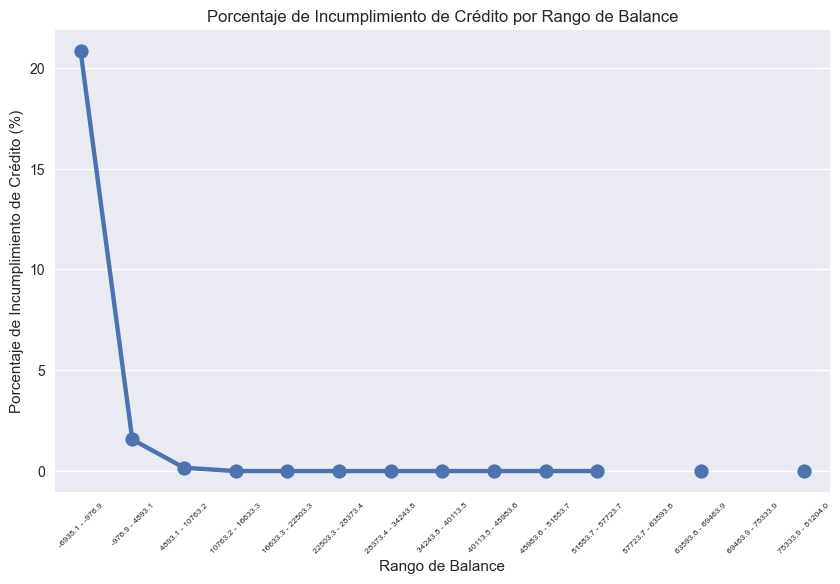

In [242]:
# Crear bins para el balance (agrupando los valores en categorías)
df_finanzas['balance_bins'] = pd.cut(df_finanzas['balance'], bins=15)  
# Calcular el porcentaje de incumplimiento por cada bin de balance
incumplimiento_por_bin = df_finanzas.groupby('balance_bins')['faltante'].mean() * 100
# Convertir el resultado a DataFrame para facilitar la visualización
incumplimiento_por_bin = incumplimiento_por_bin.reset_index()


plt.figure(figsize=(10, 6))
sns.pointplot(data=incumplimiento_por_bin, x='balance_bins', y='faltante', ci=None)

plt.title('Porcentaje de Incumplimiento de Crédito por Rango de Balance')
plt.xlabel('Rango de Balance')
plt.ylabel('Porcentaje de Incumplimiento de Crédito (%)')
plt.xticks(rotation=45, fontsize=6)
plt.gca().set_xticklabels([f'{interval.left:.1f} - {interval.right:.1f}' for interval in incumplimiento_por_bin['balance_bins']])


Observamos claramente el mismo patrón: A mayor saldo ,menor porcentaje de incumplimiento.

### PRUEBA CHI-CUADRADO

Realizamos una matriz de contingéncia para hacer la prueba estadística de Chi-Quadrado para ver si la relación entre las dos variables es significativa. 

In [243]:
def clasificacion_clientes (balance):

    if balance < Q1:
        return 'bajo'
    elif balance < Q2:
        return 'medio-bajo'
    elif balance < Q3:
        return 'medio-alto'
    else:
        return 'alto'
    
df_finanzas['descripcion_balance'] = df_finanzas['balance'].apply(clasificacion_clientes)

df_finanzas.head()

,id,age,job,marital,education,faltante,balance,housing,loan,balance_log,descripcion_balance_log,descripcion_balance,balance_bins
0,1,59,admin.,married,secondary,0,2343,1,0,9.125980,alto,alto,"(-976.933, 4893.133]"
1,3,56,admin.,married,secondary,0,45,0,0,8.838262,bajo,bajo,"(-976.933, 4893.133]"
2,4,41,technician,married,secondary,0,1270,1,0,9.001839,medio-alto,medio-alto,"(-976.933, 4893.133]"
3,5,55,services,married,secondary,0,2476,1,0,9.140347,alto,alto,"(-976.933, 4893.133]"
4,6,54,admin.,married,tertiary,0,184,0,0,8.858226,medio-bajo,medio-bajo,"(-976.933, 4893.133]"


In [244]:
import pandas as pd
import scipy.stats as stats

# Matriz de contingencia
contingencia = pd.crosstab(df_finanzas['faltante'], df_finanzas['descripcion_balance'])
print(contingencia)

# Prueba chi-cuadrado
chi2, p, _, _ = stats.chi2_contingency(contingencia)
print(f"P-valor de la prueba chi-cuadrado: {p}")

descripcion_balance  alto  bajo  medio-alto  medio-bajo
faltante                                               
0                    2790  2646        2781        2777
1                       2   137          12          17
P-valor de la prueba chi-cuadrado: 1.2526200890918415e-63


El p-valor de la prueba chi-cuadrado es muy bajo (1.25e-63) por lo que podemos concluir que hay una relación estadísticamente significativa entre estas dos variables.

### PODEMOS CONCLUIR QUE HAY UNA RELACIÓN INVERSA SIGNIFICATIVA ENTRE 'BALANCE' Y 'FALTANTE': A MAYOR SALDO , MENOR TASA DE INCUMPLIMIENTO.







# 4. CUANTIFICAR LA RELACIÓN ENTRE BALANCE E INCUMPLIMIENTO
Ahora que hemos demopstrado la relación inversa entre las dos variables vamos a cuantificarlas y objetivarlas. 

### ODDS RATIO
Comparativa de las possibilidades de incumplimiento entre las diferentes categorias de balance.

In [245]:

# Crear df's de les categorias de balance
saldo_bajo = df_finanzas[df_finanzas['descripcion_balance'] == 'bajo']
saldo_medio_bajo = df_finanzas[df_finanzas['descripcion_balance'] == 'medio-bajo']
saldo_medio_alto = df_finanzas[df_finanzas['descripcion_balance'] == 'medio-alto']
saldo_alto = df_finanzas[df_finanzas['descripcion_balance'] == 'alto']

# Calcular odds para cada categoria
odds_bajo = saldo_bajo['faltante'].mean() / (1 - saldo_bajo['faltante'].mean())
odds_medio_bajo = saldo_medio_bajo['faltante'].mean() / (1 - saldo_medio_bajo['faltante'].mean())
odds_medio_alto = saldo_medio_alto['faltante'].mean() / (1 - saldo_medio_alto['faltante'].mean())
odds_alto = saldo_alto['faltante'].mean() / (1 - saldo_alto['faltante'].mean())

print(f'Odds para saldo bajo: {odds_bajo}')
print(f'Odds para saldo medio-bajo: {odds_medio_bajo}')
print(f'Odds para saldo medio-alto: {odds_medio_alto}')
print(f'Odds para saldo alto: {odds_alto}')

odds_ratio_bajo_medio_bajo = odds_bajo / odds_medio_bajo
odds_ratio_medio_bajo_medio_alto = odds_medio_bajo / odds_medio_alto
odds_ratio_medio_alto_alto = odds_medio_alto / odds_alto


print(f'Odds ratio entre saldo bajo y saldo medio-bajo: {odds_ratio_bajo_medio_bajo}')
print(f'Odds ratio entre saldo medio-bajo y saldo medio-alto: {odds_ratio_medio_bajo_medio_alto}')
print(f'Odds ratio entre saldo medio-alto y saldo alto: {odds_ratio_medio_alto_alto}')


Odds para saldo bajo: 0.051776266061980346
Odds para saldo medio-bajo: 0.006121714079942384
Odds para saldo medio-alto: 0.004314994606256742
Odds para saldo alto: 0.0007168458781362007
Odds ratio entre saldo bajo y saldo medio-bajo: 8.457805344359967
Odds ratio entre saldo medio-bajo y saldo medio-alto: 1.4187072380266477
Odds ratio entre saldo medio-alto y saldo alto: 6.019417475728154


Esto significa que la probabilidad de incumplimiento es 8.45 veces mayor entre los clientes de saldo bajo, respecto a los de medio-bajo.
La de los de medio-bajo serà 1.41 veces mayor que la de los de medio-alto
La de los de saldo medio-alto será 6.01 veces mayor que la de los de saldo alto.

Esto significa que la probabilidad de impago augmenta mucho más en la comparación de las categorias bajo a medio-bajo seguida de la de la de medio-alto a alto.

En la parte media del saldo no hay tanta variación como en los extremos.

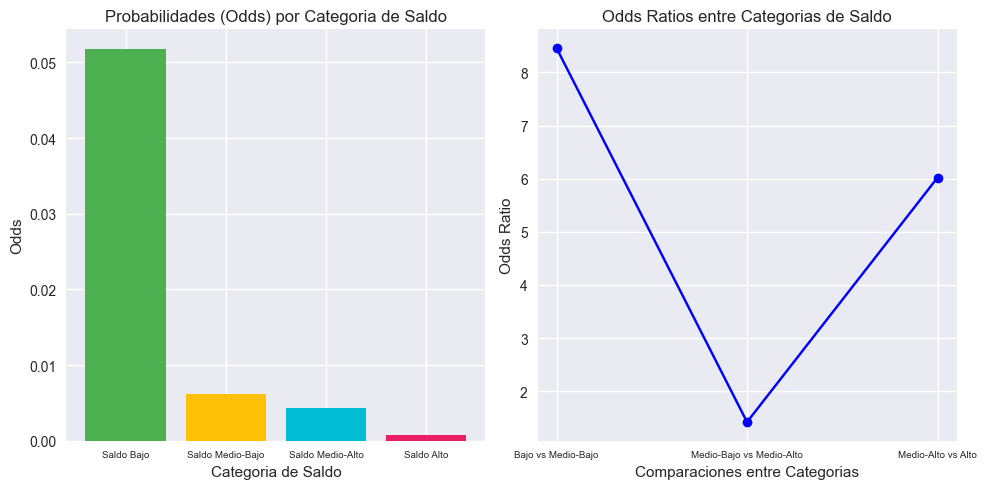

In [246]:
import matplotlib.pyplot as plt

odds = [0.051776266061980346, 0.006121714079942384, 0.004314994606256742, 0.0007168458781362007]
categories = ['Saldo Bajo', 'Saldo Medio-Bajo', 'Saldo Medio-Alto', 'Saldo Alto']

odds_ratios = [8.457805344359967, 1.4187072380266477, 6.019417475728154]
comparacions = ['Bajo vs Medio-Bajo', 'Medio-Bajo vs Medio-Alto', 'Medio-Alto vs Alto']

# Gráfico 1: Probabilidades (odds)
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.bar(categories, odds, color=['#4CAF50', '#FFC107', '#00BCD4', '#E91E63'])
plt.title('Probabilidades (Odds) por Categoria de Saldo')
plt.ylabel('Odds')
plt.xlabel('Categoria de Saldo')
plt.xticks(fontsize=7)

# Gráfico 2: Odds Ratios
plt.subplot(1, 2, 2)
plt.plot(comparacions, odds_ratios, marker='o', color='blue')
plt.title('Odds Ratios entre Categorias de Saldo')
plt.ylabel('Odds Ratio')
plt.xlabel('Comparaciones entre Categorias')
plt.xticks(fontsize=7)

plt.tight_layout()
plt.show()


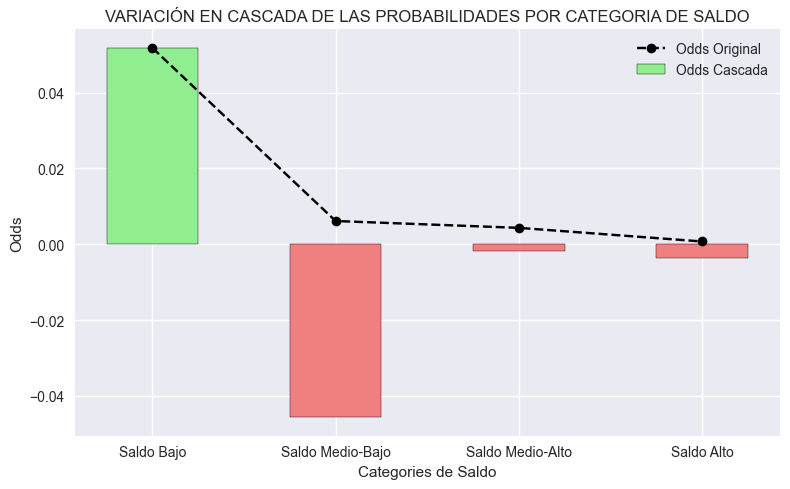

In [247]:
import matplotlib.pyplot as plt
import numpy as np

odds = [0.051776266061980346, 0.006121714079942384, 0.004314994606256742, 0.0007168458781362007]
categories = ['Saldo Bajo', 'Saldo Medio-Bajo', 'Saldo Medio-Alto', 'Saldo Alto']

# Creacion de barras acumuladas para el gráfico de cascada
initial_value = odds[0]
cascada = [initial_value]  
for i in range(1, len(odds)):
    cascada.append(odds[i] - odds[i-1])
colors = ['lightgreen' if change > 0 else 'lightcoral' for change in cascada]

# Creación del gráfico de cascada
fig, ax = plt.subplots(figsize=(8, 5))
bar_positions = np.arange(len(categories))
ax.bar(bar_positions, cascada, color=colors, edgecolor='black', width=0.5, label='Odds Cascada')

# Línea de referéncia para mostrar las "odds" originales
ax.plot(bar_positions, odds, color='black', marker='o', label='Odds Original', linestyle='--')

ax.set_xlabel('Categories de Saldo')
ax.set_ylabel('Odds')
ax.set_title('VARIACIÓN EN CASCADA DE LAS PROBABILIDADES POR CATEGORIA DE SALDO')
ax.set_xticks(bar_positions)
ax.set_xticklabels(categories)
ax.legend()

plt.tight_layout()
plt.show()


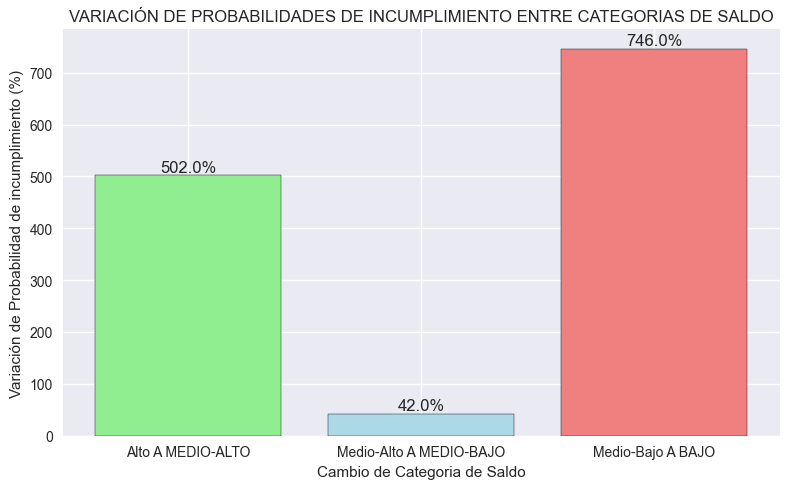

In [248]:
import matplotlib.pyplot as plt
import numpy as np

categories_cambio = ['Alto A MEDIO-ALTO', 'Medio-Alto A MEDIO-BAJO', 'Medio-Bajo A BAJO']
odds_ratios = [6.02,1.42, 8.46] 

# Incremento de probabilidades en %
increment_percent = [(odds - 1) * 100 for odds in odds_ratios]

fig, ax = plt.subplots(figsize=(8,5))
ax.bar(categories_cambio, increment_percent, color=['lightgreen', 'lightblue', 'lightcoral'], edgecolor='black')

# Etiquetas sobre las barras
for i, value in enumerate(increment_percent):
    ax.text(i, value + 1, f'{round(value, 2)}%', ha='center', va='bottom', fontsize=12)

ax.set_xlabel('Cambio de Categoria de Saldo')
ax.set_ylabel('Variación de Probabilidad de incumplimiento (%)')
ax.set_title('VARIACIÓN DE PROBABILIDADES DE INCUMPLIMIENTO ENTRE CATEGORIAS DE SALDO')

plt.tight_layout()
plt.show()


### REGRESION LOGÍSTICA
Obtener una medida de cuanto varia la probabiliad de caer en incumplimiento por cada unidad de más o de menos del saldo (balance). 

In [249]:
%pip install statsmodels
%pip install scikit-learn
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

X = df_finanzas[['balance']]  # Variable independiente 'balance'
y = df_finanzas['faltante']  # Variable dependendiente

# Constante (intercept) 
X = sm.add_constant(X)

# Dividir los datos entre conjunto de entrenamiento y conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Ajustar el modelo de regressión logística
model = sm.Logit(y_train, X_train)
result = model.fit()

print(result.summary())

predicciones = result.predict(X_test)

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Optimization terminated successfully.
         Current function value: 0.065419
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:               faltante   No. Observations:                 7813
Model:                          Logit   Df Residuals:                     7811
Method:                           MLE   Df Model:                            1
Date:                Thu, 17 Oct 2024   Pseudo R-squ.:                  0.1287
Time:                        10:43:10   Log-Likelihood:                -511.12
converged:                       True   LL-Null:                       -586.64
Covariance Type:            nonrobust   LLR p-value:                 1.029e-34
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------

#### Podemos concluir que la relación entre ambas variables es significativa aunque no es la única variable que explica el comportamiento de la variable incumplimiento. Por cada unidad de balance de más la probabilidad de caer en incumplimiento decrece un -0.19%

In [250]:
#cnx.close()